# Image Quality Assesment with CleanX

The following notes are for users with little image processing background on what the output some functions are about. 

Image quality has very specific meanings for radiologists and biomedical engineers. As image quality is balanced against other concerns such as patient safety e.g. the need for ALARA (as low as reasonably achievable) doses of radiation, higher image quality as measured by certain parameters should not always be interpreted as implying better patient care. 

Nonetheless, low image quality is not only problematic in terms of diagnostic value for individual patients, as machine learning enters diagnosis, variations in image quality present new sets of problems. 

The goal of this notebook review the tools in CleanX to examine image quality "blindly".  Here we use the word blindly in two senses. First we want to be able to assess image quality blind to the characteristics of the machines that produce it (which will be set to a certain mAs and kV, and have fixed image reconstruction algorithm possibilities, and a lot of highly technical differences and settings some of which can sometimes be encoded in the DICOM metadata). We also want to be blind in the sense that we can get meaningful results when we are not comparing any image to an "ideal" image of which it is understood as a distortion or degradation of. In electrical engineering lingo this is "blind image quality assessment." 

The cleanX blind_quality_matrix function was tested on images of the same phantoms shot at differing, but realistic, radiation levels as measured by mAs, and differing but real image reconstruction algorithms. This notebook is about our specific code, not all of the technical "domain" stuff you may need to catch up on if you are from the machine learning world. For a brief non-technical, and illustrated with chest X-rays, explanation about radiology image processing algorithms look here: https://www.upstate.edu/radiology/education/rsna/processing/

In [27]:
# # We need to get the develop branch version of cleanX  2022 (sorry, I
# # just take it off my computer)

# import sys
# sys.path = ['D:/projects/cleanX'] + sys.path

In [28]:
# Let's get going and import our libraries:
from cleanX import (
    dataset_processing as csvp,
    dicom_processing as dicomp,
    image_work as iwork,
)

In [29]:
# Other libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import cv2
#import os

In order to make this notebook more accessible to people who do not usually look at Xrays, we will first look at an image that is easier to understand for everyone- a human portrait.

OK, a bit of nerd-culture history here: The Lena image (formerly nearly synonymous with image processing algorithms) left the matplotlib library. Politics, gender, progress...there is even a movie called "Losing Lena" about this issue. Suffice it to say Lena is out and Grandma COBOL Grace Hopper is in. 

Let's make some different version of Grandma:

In [30]:
imageG = cbook.get_sample_data('grace_hopper.jpg')
imageG = plt.imread(imageG)
blurred_1 = cv2.blur(imageG, (5,5))
blurred_2 = cv2.blur(imageG, (9,9))
light_1 =  cv2.add(imageG,np.array([150.0]))
dark_2 =  cv2.add(imageG,np.array([-150.0]))
alpha, beta = 3, 0
contrasty = cv2.convertScaleAbs(imageG, alpha=alpha, beta=beta)

cv2.imwrite('granny_cam/imageG.jpeg',imageG)
cv2.imwrite('granny_cam/blurred_1.jpeg',blurred_1)
cv2.imwrite('granny_cam/blurred_2.jpeg',blurred_2)
cv2.imwrite('granny_cam/light_1.jpeg',light_1)
cv2.imwrite('granny_cam/dark_2.jpeg',dark_2)
cv2.imwrite('granny_cam/contrasty.jpeg',contrasty)

file_names = ['granny_cam/imageG.jpeg',
              'granny_cam/blurred_1.jpeg',
              'granny_cam/blurred_2.jpeg',
              'granny_cam/light_1.jpeg',
              'granny_cam/dark_2.jpeg',
              'granny_cam/contrasty.jpeg',
             ]

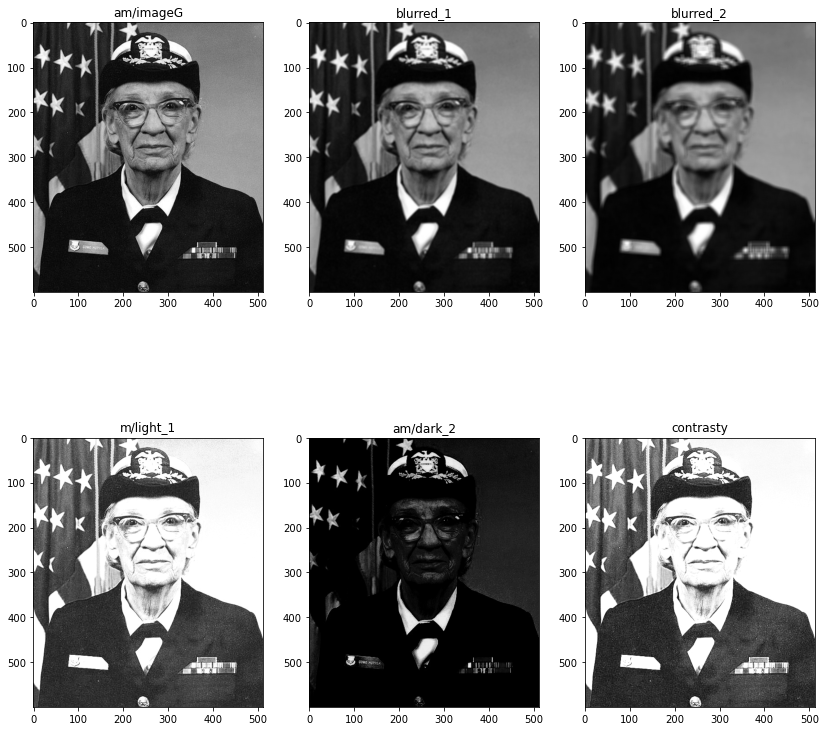

In [31]:
iwork.show_images_in_df(file_names,9)

Hopefully within seconds you can see that as we increased the kernel size we blurred on Grace got blurrier and blurrier. Blur in medical images, e.g. motion blur, can happed for several reasons beyond the scope of this notebook...but we can all see some images are just blurrier than others , or to say the same thing slightly differently, some images are crisper than others. How can we quantify that? We can use various equations we turn into functions.

But crispness is not the only thing we need to worry about. If you look at the lightened image you can see it gets harder to pick out certain details compared to the original. In photographic imaging this is analogous to images that are under- or over- exposed, and in radiology we have images that are under- or over- penetrated. 

With only two qualities (penetration and crispness) we can already see that there are separate features of image quality that will not necessarily correlate. Thus we can think of image quality in terms of multiple features, interpreted by various equations, which we can investigate.

If your eyes and mind are very sharp, and you remix the code a little, and contemplate whether there is some way of amping the contrast that us in image quality. The answer is that it's all contextual.. anyways, let's take a look at our pictures of Grace, and what the blind_quality_matrix function shows us:

In [32]:
directory1 = 'granny_cam'
iwork.blind_quality_matrix(directory1)

,name_image,pixel_sum_over_area,laplacian_variance,fastforiertransform_crispness,file_size_over_area,contrast_std,michaelson_contrast,bit_depth
0,granny_cam\blurred_1.jpeg,77.772503,35.170709,-34.389977,0.227191,64.928176,35.285713,8
1,granny_cam\blurred_2.jpeg,77.764150,9.266523,-37.668483,0.180638,62.568655,27.222221,8
2,granny_cam\contrasty.jpeg,147.492119,3275.770347,1.310295,0.429085,94.252826,1.000000,8
3,granny_cam\dark_1.jpeg,206.838675,472.722518,-17.771125,0.301979,39.866695,0.776224,8
4,granny_cam\dark_2.jpeg,8.648249,253.454800,-33.074924,0.179183,18.973453,1.000000,8
5,granny_cam\imageG.jpeg,77.779359,1046.264769,-10.689226,0.364118,67.950253,1.000000,8
6,granny_cam\light_1.jpeg,206.838675,472.722518,-17.771125,0.301979,39.866695,0.776224,8


## 1: pixel_sum_over_area
OK, we will go left to right. pixel_sum_over_area is reading in a sum of all the pixel numbers, then dividing my the area. Notice how dark_1 and dark_2 are the high and low of the column? It only makes sense- dark pixels are close to zero, and light pixels are close to 255 (once we put everything on the 0-255 scale your screen works on). Therefore we can look at pixel_sum_over_area to give us some hints about over- or under- exposure or penetration. Will a chest Xray with higher or lower pixel_sum_over_area always be differently penetrated? No. A patient with ARDS and white lungs will have a higher pixel_sum_over_area than one with emphysema...but when we group images of the same amounts of pathologies, this can indicate something when we compare the groups.   

## 2: laplacian_variance

laplacian_variance is the result of a mathematical formula for Laplacian variance that is exactly what it sounds like. Variance measures the spread inside a set of numbers. In image processing Laplacian stuff crops up in several places. For a long explanation of Laplacian operator Wikipedia is not bad. To cut to the chase, the Laplacian of an digital image tells us about of areas rapid pixel value change. Look back at our columns. Note the contrasty image had the highest variance, and the blurriest image had the least. Just what you would expect.

## 3 fastforier_transform crispiness

Here I will use some code to show what this is a all about. The python numpy library has several build in ways we can deal forier transforms. If you have time, an interesting exercise is to perform them on different image types. A Fourier transform is a very general concept often used in Physics. Usually medical people think of them as the way MRI data are made into an image. But we can use the transform on images- and that data we get out tells us (among many things)about the sharpness of the original image. Let's do a quick code example:

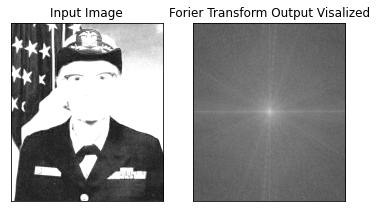

In [36]:
contrasty_ff = contrasty[:,:,0]
made_fourier = np.fft.fftshift(np.fft.fft2(contrasty_ff))
magnitude_spectrum = 20*np.log(np.abs(made_fourier))
plt.subplot(121),plt.imshow(contrasty_ff, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Forier Transform Output Visalized'), plt.xticks([]), plt.yticks([])
plt.show()

The contrasty version turned into a visualized Fourier transform. Let's see what happens when we put in our most blurred image.

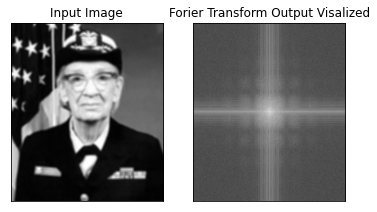

In [37]:
blurred_2_ff = blurred_2[:,:,0]
made_fourier = np.fft.fftshift(np.fft.fft2(blurred_2_ff))
magnitude_spectrum = 20*np.log(np.abs(made_fourier))
plt.subplot(121),plt.imshow(blurred_2_ff, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Forier Transform Output Visalized'), plt.xticks([]), plt.yticks([])
plt.show()

We can see the image is not the same...encoded in the Fourier transform is information about the original images- and we can exploit that to examine many things. Our functions use the fast Fourier transform to save computing time, and should be a decent surrogate for crispness in similar images. Notice the correlation with the Laplacian? Moving on... 

## 4 file_size_over_area
This variable is computed by taking the file size, and dividing it by the area (height*width). In our case the areas were all the same- because we made versions of the same image.

This parameter can be useful in more similar images to tell us something about spatial resolution, but the correlation is not perfect. Nonetheless even here our blurred and dark images (images with less information) show a smaller number than other images. 

##  5 contrast_std 
This is pretty straightforward and intuitive. One way to measure contrast is the standard deviation of the pixel numbers. 

##  6 michelson_contrast
Another way to measure contrast is through a formula of the maximum value minus the minimum divided by those two values summed

## 7 bit_depth
This is a column that will leave many sensible people scratching thier heads... our screens are always 8-bit, our eyes can see fewer gradations than that, so why worry about whether our images are 8-bit or higher? The awnser is that some types of imaging are now routinely aqcuired at 16 bit depth...and it is possible even simple digital plain films could go this way. Even if the trend never takes off, we don't want to compare 8-bit and 16-bit images in certain algorithms without knowing the difference is there. Remember the computer "sees" numbers, so bit depth matters.  

## So what?

So you can compute a bunch of numbers which tell you something about image quality. Not every image will be the same...so why should you even pay attention? I can think of at least three reasons.

1. Images that differ dramatically in the numbers for quality assessment, are often misfiled images not of chestXrays at all. As demonstrated in another notebook, sometimes people mix in CTs or other image modalities by mistake when they put datasets together quickly. When testing this on some X-rays I had I realized I had accidentally put a few images of a graph I made into the same file- I could see those images were orders of magnitude different on some measures, so I opened them.

2. Groups that are subject to social bias are often more likely to have lower quality images. Eventually these issues matter in terms of machine learning. Already we have peer reviewed evidence that some algorithms perform better in men than women (see the documentation). 

3. Classic ML CV algorithms often require inputs of relatively small images, which may be made from larger ones. We may care about how the compression we perform (assuming we do some compression) effects image quality in some cases. 